# Experimenting to properly pre-process img

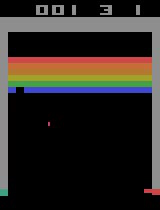

In [1]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
# original img
img = Image.open('img.jpg')
img

original dimension: (210, 160, 3)
size after transformation:  torch.Size([1, 110, 94])
torch.Size([84, 84, 1])
tensor([[[0.0078]]])


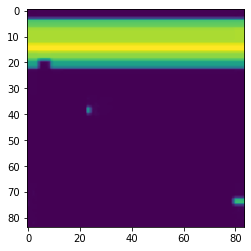

In [2]:


# number 94 is the largest without including the boundaries into the img
transform = transforms.Compose([transforms.Grayscale(),
                                       transforms.Resize((110,94)),
                                transforms.ToTensor(),
                                       ])


img = Image.open('img.jpg')
print("original dimension:", np.array(img).shape)
img = transform(img)
print("size after transformation: ", img.shape)
#transform2 = transforms.Resize(280)
#img = transform2(img) # shape (channel, height, width)
# img.shape[1] is the height of the image, only taken the lower 84 pixels of the height to avoid confusing numbers
#  img.shape[2] is the width of the image, only taken the center portion to avoid the confusing box boundaries
img = img[:,img.shape[1]-84:,img.shape[2]//2-42:img.shape[2]//2+42] 

img = np.transpose(img,(1,2,0))
plt.imshow(img)
print(img.shape)
print(img[:1,:1]) # already normalized


# Step1: Initializing the main and target CNN models

In [3]:
# imports
import cv2
import math
import numpy as np
import random
# reinforcement learning related
import re
import atari_py as ap
from collections import deque
from gym import make, ObservationWrapper, Wrapper
from gym.spaces import Box
# PyTorch imports
import torch
import torch.nn as nn
from torch import save
from torch.optim import Adam
import ale_py
import gym
import matplotlib.pyplot as plt
import PIL
import torchvision.transforms as transforms

### define the CNN model and functions such as forward passing and taking actions
It takes input size, total number of actions as input, output probability of taking each action;
the network has 3 convolutional layers with 32, 64, 64 filters with sizes 8* 8, 4* 4, 3*3

In [4]:
class CNN(nn.Module):
    def __init__(self, input_size, num_action):
        super(CNN,self).__init__()
        self._input_size = input_size
        self._num_action = num_action
        self.convLayer = nn.Sequential(
            nn.Conv2d(self._input_size[0],32,8,4),
            nn.ReLU(),
            nn.Conv2d(32,64,4,2),
            nn.ReLU(),
            nn.Conv2d(64,64,3,1),
            nn.ReLU()
        )
        self.linearLayer = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512,self._num_action)
        )
    def forward(self, x):
        # go through convolutional layers
        output = self.convLayer(x)
        # faltten the features
        output = output.view(x.size()[0],-1) # keep the batch dimension, and flatten the rest
        output = self.linearLayer(output)
        return output
    
    @property
    def feature_size(self):
        x = torch.zeros(1,*self._input_size)
        x = self.convLayer(x)
        return x.view(1,-1).size(1) # keep the first dimension as 1, and see what size the second
                                     #  dimension after flatten
    
    def take_action(self, state, eps, device):
        if random.random() > eps: # being greedy
            state = torch.from_numpy(np.double(state)).unsqueeze(0).to(device) # convert 
                #  state to float, increase a dimension, then sent to device where the model is
            state = state.float()
            # calculate Q values for each available action
            Q = self.forward(state)
            
            # choose an action accordingly
            #  torch.max(a,1) returns max values and their indices, we want the index
            #  representing the action with max Q value
            action = Q.max(1)[1].item()
        
        else: # select actions randomly
            action = random.randrange(self._num_action)
        return action
        
        

In [5]:
random.randrange(10)

5

### define the function that instantiates the main neural network and the target neural network

In [6]:
# Add the option to load trained weights!!!!!!!!!!!!
def model_initialize(env,device,path):
    main_model = CNN(env.observation_space.shape,env.action_space.n).to(device)
    target_model = CNN(env.observation_space.shape,env.action_space.n).to(device)
    if path is not None:
        main_model.load_state_dict(torch.load(path))
        target_model.load_state_dict(torch.load(path))
        print("Weights loaded")
    #print(main_model)
    return main_model, target_model

# Step2: define the experience replay buffer
store transitions (frames) of the game to train the CNN model with random sampling

In [7]:
class ReplayBuffer:
    def __init__(self, cap_max):
        # cap_max is the defined buffer size, the number of state trasitions that stored in the buffer
        self._buffer = deque(maxlen=cap_max) # use deque to speed up the append and pop operations
    
    # append (state, action, reward, next state, finish) tuple
    def push(self, state, action, reward, next_state, finish):
        self._buffer.append((state,action,reward,next_state,finish))
    
    
    def sample(self, batch_size):
        idxs = np.random.choice(len(self._buffer),batch_size,False) # chose random samples
        # e.g. idxs = (1,5,67,51,34,97,105,...)
        
        batch = zip(*[self._buffer[i] for i in idxs]) # put corresponding frames to a zipped list
        # e.g. batch = ((state_1,action_1.reward_1,next_state_1,finish_1),
        #                (state_5,action_5,reward_5,next_state_5,finish_5, ...)
        
        state, action, reward, next_state, finish = batch # create array for each category
        # e.g. state = (state_1,state_5,state_67,...)
        #      action = (action_1, action_5, action_67, ...)
        #      ...
        return (np.array(state),np.array(action),np.array(reward,dtype=float),
                 np.array(next_state),np.array(finish,dtype=np.uint8))
    
    def __len__(self):
        return len(self._buffer)

In [8]:
a = np.array([1,2,3,4,5,6,7])
np.random.choice(len(a),3,False)

array([4, 5, 6])

# Step 3: setting up environment

### define some initialization-related functions

In [9]:
# replace some string with _
def gym_to_atari_format(gym_env):
    return re.sub(r"(?<!^)(?=[A-Z])", "_", gym_env).lower()

# 
def check_atari_env(env):
    for f in ["Deterministic", "ramDeterministic", "ram", "NoFrameskip", "ramNoFrameSkip"]:
        env = env.replace(f, "")
    env = re.sub(r"-v\d+", "", env)
    env = gym_to_atari_format(env) 
    return True if env in ap.list_games() else False

### augment gym environment in a series of steps, 
include 1) downsampling the video game image frames, 2) pushing iamge frames to the experience replay buffer 3) converting images into PyTorch tnesors, ...  

In [10]:
# reseting environment for both atari or non-atari environment
class CCtrl(Wrapper):
    def __init__(self,env,is_atari):
        super(CCtrl,self).__init__(env)
        self._is_atari = is_atari
        
    def reset(self):
        if self._is_atari:
            return self.env.reset()
        else:
            self.env.reset()
            return self.env.render(mode="rgb_array")

# observations (frames) will be converted to grey-scale and reshape to (84,84)
class FrmDwSmpl(ObservationWrapper):
    def __init__(self, env):
        super(FrmDwSmpl,self).__init__(env)
        self.observation_space = Box(low=0,high=255,shape=(84,84,1),dtype=np.uint8)
        self._width=84
        self._height = 84
        
    def observation(self,observation):
        transform = transforms.Compose([transforms.ToPILImage(), # input is numpy array, have to convert to image first
                                        transforms.Grayscale(),
                                        transforms.Resize((110,94)),
                                        transforms.ToTensor(),
                                       ])
        img = observation
        #print("Original size: ",observation.shape)
        img = transform(img)
        #transform2 = transforms.Resize(280)
        #img = transform2(img) # shape (channel, height, width)
        # img.shape[1] is the height of the image, only taken the lower 84 pixels of the height to avoid confusing numbers
        #  img.shape[2] is the width of the image, only taken the center portion to avoid the confusing box boundaries
        img = img[:,img.shape[1]-84:,img.shape[2]//2-42:img.shape[2]//2+42] 
        #print("Size after transformation: ", img.shape)
        img = np.transpose(img,(1,2,0)) 
        #print("Size after transpose: ", img.shape)
        #img = img.reshape((img.shape[0],img.shape[1])) # have to get rid of the last dimension
        #print("Size after reshape: ", img.shape)
        #plt.imshow(img)
        return np.array(img)
#######################################################################################
    
# use frame-skipping technique
class MaxNSkpEnv(Wrapper):
    def __init__(self, env, atari, skip=4):
        super(MaxNSkpEnv,self).__init__(env)
        self._obs_buffer = deque(maxlen=2)
        self._skip = skip
        self._atari = atari
    
    def step(self,action):
        total_reward = 0
        finish = None
        for _ in range(self._skip):
            # take a step
            obs, reward, finish, log = self.env.step(action)
            
            # clip reward
            #reward = np.array(reward) / 100
            #reward = math.tanh(reward)
            #reward -= 0.1 # note reaonsable, there are frames can't score

            
            if not self._atari:
                obs = self.env.render(mode="rgb_array")
            # append the new stsate to the double ended queue buffer
            self._obs_buffer.append(obs)
            # accumulate the reward
            total_reward += reward
            if finish:
                break
        # buffer holds the last two frames, they are max-pooled, resulting in an observation
        #  that contains some temporal information
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, finish, log
    
    def reset(self):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs
    
    

class FrRstEnv(Wrapper):
    def __init__(self,env):
        Wrapper.__init__(self,env)
        if len(env.unwrapped.get_action_meanings()) < 3:
            raise ValueError("min requred action space of 3!")
    
    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs,_,finish,_ = self.env.step(1)
        if finish:
            self.env.reset(**kwargs)
        obs,_,finish,_ = self.env.step(2)
        if finish:
            self.env.reset(**kwargs)
        return obs
    
    def step(self, action):
        return self.env.step(action)
    

class FrmBfr(ObservationWrapper):
    def __init__(self,env,num_steps,dtype=float):
        super(FrmBfr,self).__init__(env)
        obs_space = env.observation_space
        self._dtype = dtype
        self.observation_space = Box(obs_space.low.repeat(num_steps,axis=0),
                        obs_space.high.repeat(num_steps,axis=0), dtype=self._dtype)
    
    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low,dtype=self._dtype)
        return self.observation(self.env.reset())
    
    def observation(self,observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer
#
class Img2Trch(ObservationWrapper):
    def __init__(self,env):
        super(Img2Trch,self).__init__(env)
        obs_shape = self.observation_space.shape
        self.observation_space = Box(low=0,high=1,shape=(obs_shape[::-1]),dtype=float)
    
    def observation(self,observation):
        # move the last channel to the first place, experiment!!!!!!!
        #print("input shape: ", observation.shape)
        
        obs = np.moveaxis(observation,2,0)
        #print("output shape: ", observation.shape)
        return obs

# normalizing pixel values
class NormFlts(ObservationWrapper):
    def observation(self,obs):
        return np.array(obs).astype(float) / 255




In [11]:
# experimenting get rid of the last dimension
a = np.arange(6)
x = a.reshape((3,2))
print(x)
y = a.reshape((3,2,1))
print(y)
z = y.reshape((y.shape[0],y.shape[1]))
z

[[0 1]
 [2 3]
 [4 5]]
[[[0]
  [1]]

 [[2]
  [3]]

 [[4]
  [5]]]


array([[0, 1],
       [2, 3],
       [4, 5]])

define a method that takes in the raw Pong video game environment as input and augments the environment, as follows:

In [12]:
def wrap_env(env_ip):
    env = gym.make(env_ip)
    is_atari = check_atari_env(env_ip) 
    env = CCtrl(env, is_atari) # preparing to reseting environment
    env = MaxNSkpEnv(env, is_atari) # initialize frame-skipping technique
    try:
        env_acts = env.unwrapped.get_action_meanings()
        if "FIRE" in env_acts:
            env = FrRstEnv(env)
    except AttributeError:
        pass
    env = FrmDwSmpl(env) # preprocessing pixels
    env = Img2Trch(env) # convert to tensor >
    env = FrmBfr(env,4) # initilize frame buffers
    #env = NormFlts(env) # normalize pixel values
    return env
        

# Step 4: Defining the CNN optimization function

In [13]:
def convert(data,device):
    # data should be a numpy array
    return torch.from_numpy(data).to(device)

In [15]:
# loss function
def calc_temp_diff_loss(main_model,target_model,batch,gamma,device, ep):
    state, action, reward, next_state, finish = batch
    
    #reward = np.array(reward) / 100 # taking too much memory, directly change the reward as reward / 100
    
    # put tensors to cuda
    state = convert(state,device).float() 
    next_state = convert(next_state,device).float()
    action = convert(action,device)
    reward = convert(reward,device) # clipped reward
    finish = convert(finish,device)
    
    # use behavior policy to calculate current state action values
    Q_vals = main_model(state)
    
    # use target policy (greedy) to calculate state action values for next state
    next_Q_vals = target_model(next_state)
    
    action = action.long()
    
    # experiment!!!!!!!!!!!!!!!!!!
    Q_val = Q_vals.gather(1,action.unsqueeze(-1)).squeeze(-1)
    #print(Q_val)
    
    # index 0 because we wish to know the max q-value for next state, not which action that cause the max value
    next_Q_val = next_Q_vals.max(1)[0]
    
    # calculate the loss 
    expected_Q_val = reward + gamma * next_Q_val * (1-finish) 
    #print(expected_Q_val)
    #print(reward)
    #loss_fn = torch.nn.HuberLoss()
    loss_fn = torch.nn.MSELoss()
    Q_val, expected_Q_val = Q_val.float(), expected_Q_val.float()
    loss = loss_fn(Q_val,expected_Q_val) + 0.1 * Q_val.mean()
    

    
    return loss

In [16]:
a = [13,105,198,640]
b = torch.tensor(a) / 100
b

tensor([0.1300, 1.0500, 1.9800, 6.4000])

In [17]:
# updating function: samples a batch of data from the reperiemnce replay buffer,
#  computes the time difference loss on the batch, copies the weights of the main model
#  to the target model once every TGT_UPD_FRQ iterations
def update_graph(main_model,target_model,opt,buffer,device,log,ep):
    if len(buffer) >= INIT_LEARN:
        # let me know that the learning starts
        if len(buffer) == INIT_LEARN:
            print("\nLearning starts!\n")
        
        # let me know when buffer size is reached, (not letting this equal MEM_CAP is because I don't want print it everytime)
        if len(buffer) == MEM_CAP - 2:
            print("\nbuffer is full\n")
        
        # copy the wieghts main model to target model every 5000 iterations
        if ep < TGT_UPD_TH:
            k = TGT_UPD_FRQ1
        else:
            k = TGT_UPD_FRQ2
        
        
        if log.idx % k == 0: 
            target_model.load_state_dict(main_model.state_dict())
        
        # calculate predictions (action values) loss and update the weights in the model 
        opt.zero_grad() # clear cache
        batch = buffer.sample(B_S) # B_S is hyperparameter, sample B_S tuples of (state,...)
        loss = calc_temp_diff_loss(main_model,target_model,batch,G, device, ep)
        loss = loss.float()
        loss.backward()
        opt.step()
        

# Step5: managing and running episodes

In [18]:
# define the function to update the epsillon value after each episode
# the first 10 episodes will be more exploring
# the last 100 episodes will be pure greedy
def update_eps(epd,ep):
    #if ep <= 10:
        #return 0.5
    #elif ep >= N_EPDS - 100 - 1:
        #return 0
    
    last_eps = EPS_FINL
    first_eps = EPS_START
    # control rate of decay, the later phase, decay slower
    rate_decay = (epd+1) / EPS_DECAY
    if rate_decay < DECAY_TH:
        eps = last_eps + (first_eps - last_eps) * math.exp(-1*rate_decay)
    else:
        if rate_decay == DECAY_TH:
            print("\nForcing Slower Decay Start\n")
        eps = last_eps + (first_eps - last_eps) * math.exp(-1 * rate_decay) * (rate_decay+(1-DECAY_TH))
    return eps

In [19]:
# define the function to take action after end of an episode
#  if the overall reward that's scored in the current episode is the best we've achieved so far
#  we save the CNN model weights and print the reward value
def finish_episode(main_model,env,log,ep_reward,ep,eps):
    best_so_far = log.update_rewards(ep_reward)
    log.update_average_rewards()
    
    #if best_so_far and (ep <= N_EPDS - 100 - 1):
    if best_so_far:
        print(f"\nhighest running_average_reward of {round(log.best_average,3)} achieved!\n")
        save(main_model.state_dict(),f"Weights/{env}.pth")

    # display every 3 episodes
    #if ep % 3 == 0:
    print(f"EP {round(ep,1)}, curr_reward: {round(ep_reward,1)}, best_reward: {round(log.best_reward,1)}, running_avg_reward: {round(log.average, 3)}, curr_epsilon: {round(eps, 4)}")
    return eps

In [30]:
# define the DQN loop
def run_episodes(env,main_model,target_model,buffer,device,log,ep):
    # initializing
    episode_reward = 0.0
    state = env.reset()
    # first 50 episodes: lr = 1e-5, 50-300: 6e-6, >300: 2e-6, >1000: 1e-6
    if ep < EP_TH1:
        lr = LR1
    elif ep < EP_TH2:
        lr = LR2
    elif ep < EP_TH3:
        lr = LR3
    else:
        lr = LR4
    optimizer = Adam(main_model.parameters(),lr=lr)
    
    
    while True: 
        eps = update_eps(log.idx,ep) # update episolon based on current episode number
        #eps = EPS
        action = main_model.take_action(state,eps,device) # choose an action to take
        #if ep >= N_EPDS - 100 - 1: # display the game for the final 100 episodes
            #env.render() # display the environment
        #env.render()
        next_state, reward, finish, _ = env.step(action)  # take the action
        buffer.push(state,action,reward,next_state,finish) # push current tuple to buffer
        
        # prepare for next iteration
        state = next_state 
        episode_reward += reward
        log.update_idx()
        

        
        update_graph(main_model,target_model,optimizer,buffer,device,log,ep) # perform learning - add ep parameter

        # break if reached end of the episode
        if finish:
            eps = finish_episode(main_model,ENV,log,episode_reward,ep,eps)
            return eps

# Step 6: define the matadata class

In [22]:
class TrMetadata:
    def __init__(self):
        self._average = 0.0
        self._best_reward = -float("inf")
        self._best_average = -float("inf")
        self._rewards = []
        self._average_rewards = [] # keep track of average rewards
        self._average_range = 100
        self._idx = 0
        self._best_rewards = [] # keep track of best rewards
    
    @property
    def best_reward(self):
        return self._best_reward
    
    @property
    def best_average(self):
        return self._best_average
    
    @property
    def average(self):
        average_range = self._average_range * -1
        average_reward = sum(self._rewards[average_range:]) / len(self._rewards[average_range:])
        return average_reward
    
    @property
    def idx(self):
        return self._idx
    
    def _update_best_reward(self,episode_reward):
        self._best_rewards.append(self._best_reward)
        if episode_reward > self.best_reward:
            self._best_reward = episode_reward
            
    
    def _update_best_average(self):
        if self.average > self.best_average:
            self._best_average = self.average
            return True
        return False
    
    def update_rewards(self,episode_reward):
        self._rewards.append(episode_reward)
        self._update_best_reward(episode_reward)
        return self._update_best_average()
    
    def update_average_rewards(self):
        self._average_rewards.append(self.average)
    
    def update_idx(self):
        self._idx += 1

# Step 7: training

In [23]:
from tqdm.auto import tqdm

def train(env,main_model,target_model,buffer,device):    
    log = TrMetadata()
    progress = tqdm(range(N_EPDS))
    epss = [] # keep track of epsilons
    
    
    for ep in np.arange(N_EPDS):
        
        # record how many iterations per episode every 50 episode
        if ep % 25 == 0:
            start = log.idx
            eps = run_episodes(env,main_model,target_model,buffer,device,log,ep)
            print(f"\nThis episode takes {log.idx-start} iterations\n")
        else:
            eps = run_episodes(env,main_model,target_model,buffer,device,log,ep)
        epss.append(eps)
        
        # if the precentage difference between the current average and best average exceed diff, break
        threshold = max(DIFF_P * log._best_average, DIFF)
        if ((log._best_average - log.average) > threshold) and (ep>=BREAK_TH):
            save(main_model.state_dict(),f"Weights/{env}_last.pth")
            return log._average_rewards, log._rewards, log._best_rewards, ep, epss
        
        progress.update(1)
    
    # return rewrads and average rewards
    save(main_model.state_dict(),f"Weights/{env}_last.pth")
    return log._average_rewards, log._rewards, log._best_rewards, ep, epss

In [24]:
# hypterparameters 
B_S = 64 # batch size per SGD calculation
#ENV = "SpaceInvaders-v0"
ENV = "Breakout-v0"
EPS_START = 1.0
EPS_FINL = 0.01 # this could be changed because less actions are taken
EPS_DECAY = 100 * 1000 # around 500 episodes arive at threshold: 0.3, assuming 100 frames per episode
#EPS_DECAY = 75000
#EPS_DECAY2 = 400000 # decaying 4 time faster - 25000, 50000, made it unstable
G = 0.99 # gamma changed from 0.99
INIT_LEARN = 300 # initial number of iterations that are reserved for pushing data
                   #  to the buffer
LR1 = 2e-4 # changed from 1e-5
LR2 = 1e-4 # changed from 6e-6
LR3 = 8e-5 # changed from 2e-6, 1e-6
LR4 = 1e-5 # changed from 1e-6
MEM_CAP = 40000 #size of experience replay buffer - can take more

TGT_UPD_FRQ1 = 1000 # changed from 8000, 10000, 15000
TGT_UPD_FRQ2 = 3000 # changed from 16000, 20000, 30000
TGT_UPD_TH = 2000 # threshold for updating target model weights

EP_TH1 = 1000 # threshold for updating learning rate
EP_TH2 = 2000
EP_TH3 = 5000

BREAK_TH = 200 # threshold for starting considering differeince in average learning
DIFF_P = 0.3 # if average reward is less than best average reward for more than 5, break, replace with percentage
DIFF = 4

DECAY_TH = 0.7

# Initialization - run every time

In [25]:
# start training
env = wrap_env(ENV)
device = "cuda"
#path = "Weights/" + ENV + "_runC_2_2.pth"
path = None
main_model, target_model = model_initialize(env,device,path)


In [26]:
def plot_rewards(re,num_eps,reward_type,run):
    # plot and save the figure
    plt.figure(figsize=(12,8))
    x = np.arange(1,num_eps+1)
    filepath = "Figs_BK/run_"+str(run)+"_"+reward_type+"_"+str(num_eps)+"_episode.jpg"
    plt.plot(x,re)
    plt.xlabel("Episodes")
    plt.ylabel(f"{reward_type} Reward")
    plt.title(f"{reward_type} rewards for {num_eps} episodes")
    plt.savefig(filepath)
    plt.show()
    
    # save the array
    arraypath = "Rewards_BK/run_"+str(run)+"_"+reward_type+"_"+str(num_eps)+"_episode.npy"
    np.save(arraypath,re)
    

In [27]:
def pretty_plot(re,ave_re,best_re,run):
    plt.figure(figsize=(12,8))
    x = np.arange(1,len(re)+1)
    plt.plot(x,re,color=(0.999,0.8,0.9))
    plt.plot(x,ave_re,color=(0.9,0,0))
    plt.plot(x,best_re,color=(0,0,0.9))
    plt.legend(["Rewards", "Average Rewards", "Best Rewards"],loc="lower right")
    plt.title(f"Overview of rewards achieved in run {run}")
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    filepath = "PrettyFig_BK/run_"+str(run)+".jpg"
    plt.savefig(filepath)
    plt.show()

In [28]:
def plot_eps(eps, run):
    plt.figure(figsize=(12,8))
    x = np.arange(1, len(eps)+1)
    plt.plot(x,eps,color=(0,0,0.9))
    plt.title(f"Epsilon Decaying Schedule in run {run}")
    plt.xlabel("Episodes")
    plt.ylabel("Episolon")
    filepath = "PrettyFig_BK/EPS_run_" + str(run) + ".jpg"
    plt.savefig(filepath)
    plt.show()
    

# make sure the pre-processing is okay

  0%|          | 0/2 [00:00<?, ?it/s]

Size after reshape:  torch.Size([84, 84, 1])
input shape:  (84, 84, 1)
output shape:  (84, 84, 1)
Size after reshape:  torch.Size([84, 84, 1])
input shape:  (84, 84, 1)
output shape:  (84, 84, 1)

This episode takes 1 iterations

Size after reshape:  torch.Size([84, 84, 1])
input shape:  (84, 84, 1)
output shape:  (84, 84, 1)
Size after reshape:  torch.Size([84, 84, 1])
input shape:  (84, 84, 1)
output shape:  (84, 84, 1)


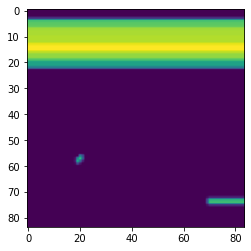

In [34]:
ave_re, re, best_re,ep, epss = train(env,main_model,target_model,buffer,device)
env.close()

# Run 1 - v4

In [42]:

# with batch_size 64
N_EPDS = math.floor(2000)  # total number of episodes to train the agent for


EPS_START = 1
EPS_FINL = 0.1

EPS_DECAY = 60 * 400# epd equals EPS_DECAY approximately 300 episodes, assuming 200 frames per episode, slowing start are 600 episodes
DECAY_TH = 1 # start slowing decay at rate = 1, eps = 0.43.

DIFF = 0
DIFF_P = 0.5
BREAK_TH = 500

EP_TH1 = 1000 # threshold for updating learning rate
EP_TH2 = 2000
EP_TH3 = 5000
LR1 = 2e-4 # changed from 1e-5
LR2 = 8e-5 # changed from 6e-6
LR3 = 5e-5 # changed from 2e-6, 1e-6
LR4 = 1e-7 # changed from 1e-6

TGT_UPD_FRQ1 = 300 # update approximately 10 episodes
TGT_UPD_FRQ2 = 900# change to maybe 18 episodes after 800 episodes
TGT_UPD_TH = 400
buffer = ReplayBuffer(MEM_CAP)

In [28]:
ave_re, re, best_re,ep, epss = train(env,main_model,target_model,buffer,device)
env.close()

  0%|          | 0/2000 [00:00<?, ?it/s]


highest running_average_reward of 0.0 achieved!

EP 0, curr_reward: 0.0, best_reward: 0.0, running_avg_reward: 0.0, curr_epsilon: 0.9985

This episode takes 41 iterations


highest running_average_reward of 1.0 achieved!

EP 1, curr_reward: 2.0, best_reward: 2.0, running_avg_reward: 1.0, curr_epsilon: 0.9956

highest running_average_reward of 1.333 achieved!

EP 2, curr_reward: 2.0, best_reward: 2.0, running_avg_reward: 1.333, curr_epsilon: 0.9925
EP 3, curr_reward: 0.0, best_reward: 2.0, running_avg_reward: 1.0, curr_epsilon: 0.9907

Learning starts!

EP 4, curr_reward: 2.0, best_reward: 2.0, running_avg_reward: 1.2, curr_epsilon: 0.9879
EP 5, curr_reward: 2.0, best_reward: 2.0, running_avg_reward: 1.333, curr_epsilon: 0.9852

highest running_average_reward of 1.429 achieved!

EP 6, curr_reward: 2.0, best_reward: 2.0, running_avg_reward: 1.429, curr_epsilon: 0.9819
EP 7, curr_reward: 0.0, best_reward: 2.0, running_avg_reward: 1.25, curr_epsilon: 0.9801
EP 8, curr_reward: 1.0, best_re

EP 84, curr_reward: 3.0, best_reward: 5.0, running_avg_reward: 1.388, curr_epsilon: 0.8073
EP 85, curr_reward: 2.0, best_reward: 5.0, running_avg_reward: 1.395, curr_epsilon: 0.8053
EP 86, curr_reward: 8.0, best_reward: 8.0, running_avg_reward: 1.471, curr_epsilon: 0.801
EP 87, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.477, curr_epsilon: 0.7988
EP 88, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.472, curr_epsilon: 0.7968
EP 89, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.456, curr_epsilon: 0.7954
EP 90, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.44, curr_epsilon: 0.794
EP 91, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.424, curr_epsilon: 0.7926
EP 92, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.409, curr_epsilon: 0.7912
EP 93, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.394, curr_epsilon: 0.7897
EP 94, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.4, curr_epsilon: 0.7878
EP 9

EP 174, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.31, curr_epsilon: 0.6485
EP 175, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.3, curr_epsilon: 0.6472

This episode takes 58 iterations

EP 176, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.3, curr_epsilon: 0.6459
EP 177, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.29, curr_epsilon: 0.6447
EP 178, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.3, curr_epsilon: 0.6427
EP 179, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.29, curr_epsilon: 0.6417
EP 180, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.26, curr_epsilon: 0.6402
EP 181, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.26, curr_epsilon: 0.6393
EP 182, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.24, curr_epsilon: 0.6377
EP 183, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.22, curr_epsilon: 0.6365
EP 184, curr_reward: 2.0, best_reward: 8.0, running_avg_re

EP 260, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.61, curr_epsilon: 0.5231
EP 261, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.61, curr_epsilon: 0.5219

highest running_average_reward of 1.64 achieved!

EP 262, curr_reward: 5.0, best_reward: 8.0, running_avg_reward: 1.64, curr_epsilon: 0.5197
EP 263, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.63, curr_epsilon: 0.5188
EP 264, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.61, curr_epsilon: 0.5178
EP 265, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.62, curr_epsilon: 0.5167
EP 266, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.61, curr_epsilon: 0.5152
EP 267, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.61, curr_epsilon: 0.5138
EP 268, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.61, curr_epsilon: 0.5122
EP 269, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.58, curr_epsilon: 0.5111
EP 270, curr_reward: 3.0, best_reward: 

EP 341, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.76, curr_epsilon: 0.4311
EP 342, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.75, curr_epsilon: 0.4311
EP 343, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.76, curr_epsilon: 0.431
EP 344, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.78, curr_epsilon: 0.431
EP 345, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.77, curr_epsilon: 0.431
EP 346, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.76, curr_epsilon: 0.431
EP 347, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.76, curr_epsilon: 0.431
EP 348, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.77, curr_epsilon: 0.431
EP 349, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.76, curr_epsilon: 0.4309
EP 350, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.74, curr_epsilon: 0.4309

This episode takes 42 iterations

EP 351, curr_reward: 4.0, best_reward: 8.0, running_avg_rewar

EP 430, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.59, curr_epsilon: 0.4198
EP 431, curr_reward: 3.0, best_reward: 8.0, running_avg_reward: 1.61, curr_epsilon: 0.4194
EP 432, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.57, curr_epsilon: 0.4192
EP 433, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.57, curr_epsilon: 0.419
EP 434, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.59, curr_epsilon: 0.4188
EP 435, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.6, curr_epsilon: 0.4186
EP 436, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.58, curr_epsilon: 0.4184
EP 437, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.59, curr_epsilon: 0.4181
EP 438, curr_reward: 3.0, best_reward: 8.0, running_avg_reward: 1.61, curr_epsilon: 0.4178
EP 439, curr_reward: 3.0, best_reward: 8.0, running_avg_reward: 1.63, curr_epsilon: 0.4176
EP 440, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.62, curr_epsilon: 0.4173
E

EP 520, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.21, curr_epsilon: 0.397
EP 521, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.19, curr_epsilon: 0.3967
EP 522, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.18, curr_epsilon: 0.3965
EP 523, curr_reward: 3.0, best_reward: 8.0, running_avg_reward: 1.2, curr_epsilon: 0.3961
EP 524, curr_reward: 3.0, best_reward: 8.0, running_avg_reward: 1.22, curr_epsilon: 0.3957
EP 525, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.22, curr_epsilon: 0.3955

This episode takes 55 iterations

EP 526, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.2, curr_epsilon: 0.3953
EP 527, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.19, curr_epsilon: 0.395
EP 528, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.21, curr_epsilon: 0.3947
EP 529, curr_reward: 3.0, best_reward: 8.0, running_avg_reward: 1.22, curr_epsilon: 0.3943
EP 530, curr_reward: 0.0, best_reward: 8.0, running_avg_rew

EP 609, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.45, curr_epsilon: 0.3678
EP 610, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.46, curr_epsilon: 0.3675
EP 611, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.42, curr_epsilon: 0.3672
EP 612, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.38, curr_epsilon: 0.367
EP 613, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.38, curr_epsilon: 0.3666
EP 614, curr_reward: 3.0, best_reward: 8.0, running_avg_reward: 1.41, curr_epsilon: 0.3662
EP 615, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.41, curr_epsilon: 0.3658
EP 616, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.4, curr_epsilon: 0.3655
EP 617, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.41, curr_epsilon: 0.3651
EP 618, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.41, curr_epsilon: 0.3649
EP 619, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.41, curr_epsilon: 0.3646
E

EP 698, curr_reward: 3.0, best_reward: 8.0, running_avg_reward: 1.46, curr_epsilon: 0.3352
EP 699, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.46, curr_epsilon: 0.3349
EP 700, curr_reward: 7.0, best_reward: 8.0, running_avg_reward: 1.51, curr_epsilon: 0.334

This episode takes 187 iterations

EP 701, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.51, curr_epsilon: 0.3336
EP 702, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.5, curr_epsilon: 0.3333
EP 703, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.5, curr_epsilon: 0.3329
EP 704, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.5, curr_epsilon: 0.3325
EP 705, curr_reward: 3.0, best_reward: 8.0, running_avg_reward: 1.51, curr_epsilon: 0.332
EP 706, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.51, curr_epsilon: 0.3316
EP 707, curr_reward: 3.0, best_reward: 8.0, running_avg_reward: 1.52, curr_epsilon: 0.3312
EP 708, curr_reward: 1.0, best_reward: 8.0, running_avg_rew

EP 787, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.34, curr_epsilon: 0.3021
EP 788, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.33, curr_epsilon: 0.3018
EP 789, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.32, curr_epsilon: 0.3016
EP 790, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.29, curr_epsilon: 0.3013
EP 791, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.27, curr_epsilon: 0.301
EP 792, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.26, curr_epsilon: 0.3007
EP 793, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.26, curr_epsilon: 0.3003
EP 794, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.27, curr_epsilon: 0.2999
EP 795, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.25, curr_epsilon: 0.2995
EP 796, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.25, curr_epsilon: 0.2992
EP 797, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.25, curr_epsilon: 0.2988


EP 876, curr_reward: 3.0, best_reward: 8.0, running_avg_reward: 1.0, curr_epsilon: 0.2715
EP 877, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.01, curr_epsilon: 0.2711
EP 878, curr_reward: 3.0, best_reward: 8.0, running_avg_reward: 1.01, curr_epsilon: 0.2706
EP 879, curr_reward: 4.0, best_reward: 8.0, running_avg_reward: 1.05, curr_epsilon: 0.2701
EP 880, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.04, curr_epsilon: 0.2698
EP 881, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.04, curr_epsilon: 0.2696
EP 882, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.03, curr_epsilon: 0.2693
EP 883, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.03, curr_epsilon: 0.269
EP 884, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.05, curr_epsilon: 0.2687
EP 885, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.05, curr_epsilon: 0.2684
EP 886, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.04, curr_epsilon: 0.2682
E

EP 966, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.28, curr_epsilon: 0.2426
EP 967, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.27, curr_epsilon: 0.2424
EP 968, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.25, curr_epsilon: 0.2422
EP 969, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.26, curr_epsilon: 0.2418
EP 970, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.26, curr_epsilon: 0.2414
EP 971, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.25, curr_epsilon: 0.2412
EP 972, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.25, curr_epsilon: 0.241
EP 973, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.26, curr_epsilon: 0.2408
EP 974, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.26, curr_epsilon: 0.2405
EP 975, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.26, curr_epsilon: 0.2403

This episode takes 57 iterations

EP 976, curr_reward: 1.0, best_reward: 8.0, running_avg_

EP 1055, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.52, curr_epsilon: 0.2178
EP 1056, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.51, curr_epsilon: 0.2176
EP 1057, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.52, curr_epsilon: 0.2174
EP 1058, curr_reward: 4.0, best_reward: 8.0, running_avg_reward: 1.55, curr_epsilon: 0.217
EP 1059, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.57, curr_epsilon: 0.2167
EP 1060, curr_reward: 4.0, best_reward: 8.0, running_avg_reward: 1.61, curr_epsilon: 0.2161
EP 1061, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.6, curr_epsilon: 0.2159
EP 1062, curr_reward: 4.0, best_reward: 8.0, running_avg_reward: 1.62, curr_epsilon: 0.2156
EP 1063, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.59, curr_epsilon: 0.2154
EP 1064, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.57, curr_epsilon: 0.2152
EP 1065, curr_reward: 3.0, best_reward: 8.0, running_avg_reward: 1.59, curr_epsilo

EP 1144, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.39, curr_epsilon: 0.1961
EP 1145, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.38, curr_epsilon: 0.1959
EP 1146, curr_reward: 3.0, best_reward: 8.0, running_avg_reward: 1.41, curr_epsilon: 0.1956
EP 1147, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.37, curr_epsilon: 0.1954
EP 1148, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.39, curr_epsilon: 0.1952
EP 1149, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.38, curr_epsilon: 0.195
EP 1150, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.39, curr_epsilon: 0.1948

This episode takes 70 iterations

EP 1151, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.39, curr_epsilon: 0.1947
EP 1152, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.38, curr_epsilon: 0.1945
EP 1153, curr_reward: 4.0, best_reward: 8.0, running_avg_reward: 1.42, curr_epsilon: 0.1941
EP 1154, curr_reward: 3.0, best_reward: 8.0, r

EP 1232, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.11, curr_epsilon: 0.1794
EP 1233, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.08, curr_epsilon: 0.1793
EP 1234, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.08, curr_epsilon: 0.1791
EP 1235, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.08, curr_epsilon: 0.179
EP 1236, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.06, curr_epsilon: 0.1788
EP 1237, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.06, curr_epsilon: 0.1787
EP 1238, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.04, curr_epsilon: 0.1785
EP 1239, curr_reward: 2.0, best_reward: 8.0, running_avg_reward: 1.05, curr_epsilon: 0.1784
EP 1240, curr_reward: 1.0, best_reward: 8.0, running_avg_reward: 1.05, curr_epsilon: 0.1782
EP 1241, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.05, curr_epsilon: 0.1781
EP 1242, curr_reward: 0.0, best_reward: 8.0, running_avg_reward: 1.05, curr_epsil

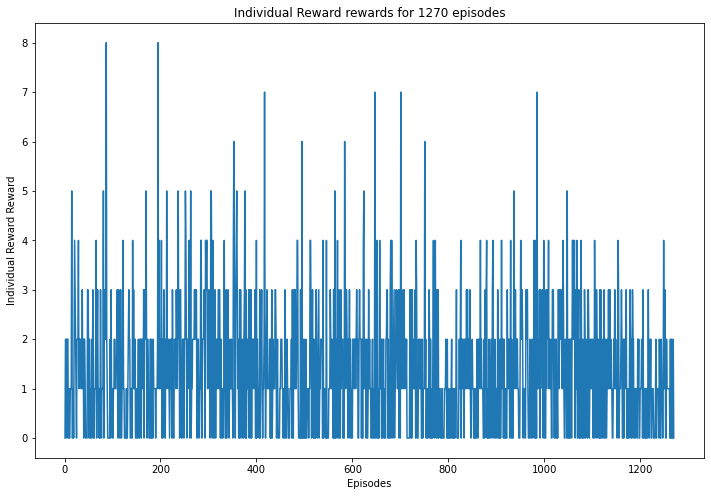

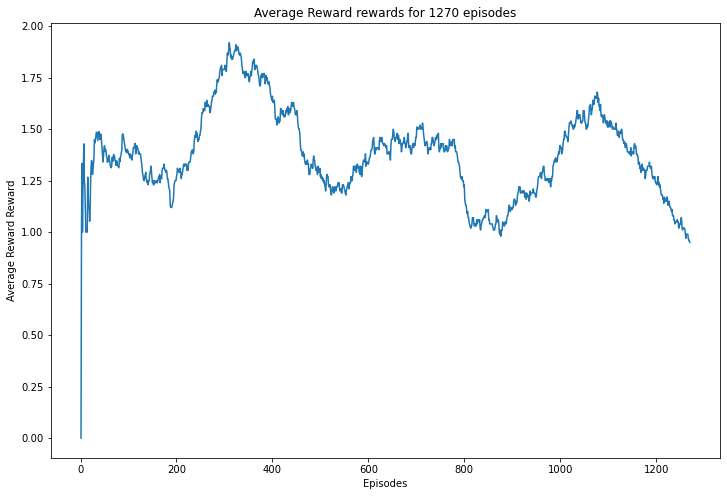

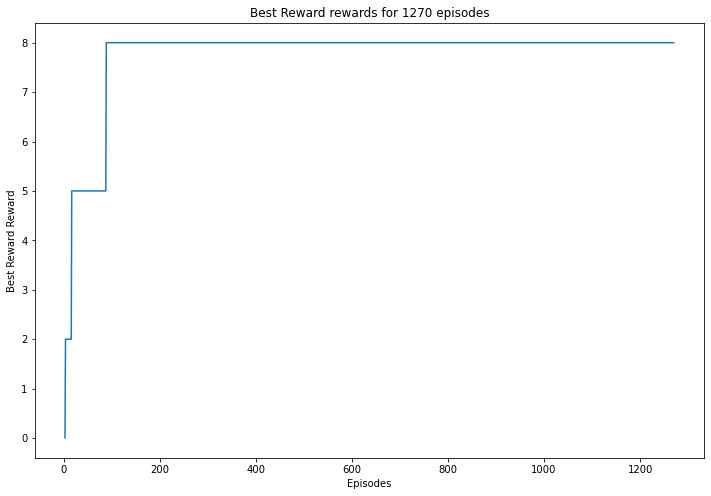

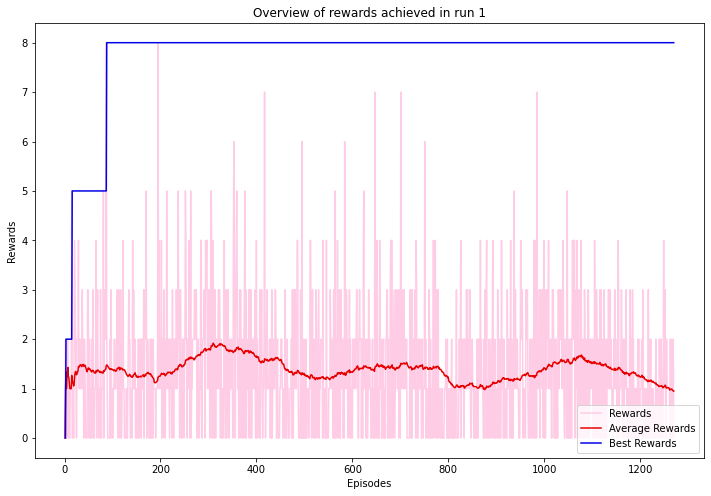

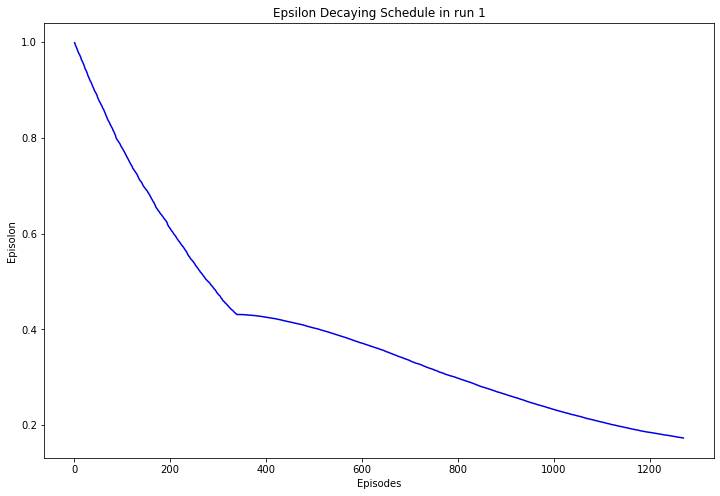

In [29]:
plot_rewards(re,ep+1,"Individual Reward",1)
plot_rewards(ave_re,ep+1,"Average Reward",1)
plot_rewards(best_re,ep+1,"Best Reward",1)
pretty_plot(re,ave_re,best_re,1)
plot_eps(epss,1)

# Run 1 - v0

In [31]:

# with batch_size 64
N_EPDS = math.floor(2000)  # total number of episodes to train the agent for


EPS_START = 1
EPS_FINL = 0.1

EPS_DECAY = 60 * 400# epd equals EPS_DECAY approximately 300 episodes, assuming 200 frames per episode, slowing start are 600 episodes
DECAY_TH = 1 # start slowing decay at rate = 1, eps = 0.43.

DIFF = 0
DIFF_P = 0.5
BREAK_TH = 500

EP_TH1 = 1000 # threshold for updating learning rate
EP_TH2 = 2000
EP_TH3 = 5000
LR1 = 2e-4 # changed from 1e-5
LR2 = 8e-5 # changed from 6e-6
LR3 = 5e-5 # changed from 2e-6, 1e-6
LR4 = 1e-7 # changed from 1e-6

TGT_UPD_FRQ1 = 300 # update approximately 10 episodes
TGT_UPD_FRQ2 = 900# change to maybe 18 episodes after 800 episodes
TGT_UPD_TH = 400
buffer = ReplayBuffer(MEM_CAP)

In [32]:
ave_re, re, best_re,ep, epss = train(env,main_model,target_model,buffer,device)
env.close()

  0%|          | 0/2000 [00:00<?, ?it/s]


highest running_average_reward of 1.0 achieved!

EP 0, curr_reward: 1.0, best_reward: 1.0, running_avg_reward: 1.0, curr_epsilon: 0.9978

This episode takes 60 iterations

EP 1, curr_reward: 1.0, best_reward: 1.0, running_avg_reward: 1.0, curr_epsilon: 0.9958
EP 2, curr_reward: 1.0, best_reward: 1.0, running_avg_reward: 1.0, curr_epsilon: 0.9935
EP 3, curr_reward: 0.0, best_reward: 1.0, running_avg_reward: 0.75, curr_epsilon: 0.9918

highest running_average_reward of 1.2 achieved!

EP 4, curr_reward: 3.0, best_reward: 3.0, running_avg_reward: 1.2, curr_epsilon: 0.989

Learning starts!

EP 5, curr_reward: 0.0, best_reward: 3.0, running_avg_reward: 1.0, curr_epsilon: 0.9869
EP 6, curr_reward: 2.0, best_reward: 3.0, running_avg_reward: 1.143, curr_epsilon: 0.9842

highest running_average_reward of 1.375 achieved!

EP 7, curr_reward: 3.0, best_reward: 3.0, running_avg_reward: 1.375, curr_epsilon: 0.981

highest running_average_reward of 1.778 achieved!

EP 8, curr_reward: 5.0, best_reward

EP 87, curr_reward: 3.0, best_reward: 5.0, running_avg_reward: 1.364, curr_epsilon: 0.8026
EP 88, curr_reward: 0.0, best_reward: 5.0, running_avg_reward: 1.348, curr_epsilon: 0.8012
EP 89, curr_reward: 0.0, best_reward: 5.0, running_avg_reward: 1.333, curr_epsilon: 0.7998
EP 90, curr_reward: 3.0, best_reward: 5.0, running_avg_reward: 1.352, curr_epsilon: 0.7973
EP 91, curr_reward: 3.0, best_reward: 5.0, running_avg_reward: 1.37, curr_epsilon: 0.7946
EP 92, curr_reward: 2.0, best_reward: 5.0, running_avg_reward: 1.376, curr_epsilon: 0.7926
EP 93, curr_reward: 4.0, best_reward: 5.0, running_avg_reward: 1.404, curr_epsilon: 0.7893
EP 94, curr_reward: 3.0, best_reward: 5.0, running_avg_reward: 1.421, curr_epsilon: 0.787
EP 95, curr_reward: 2.0, best_reward: 5.0, running_avg_reward: 1.427, curr_epsilon: 0.785
EP 96, curr_reward: 3.0, best_reward: 5.0, running_avg_reward: 1.443, curr_epsilon: 0.7829
EP 97, curr_reward: 1.0, best_reward: 5.0, running_avg_reward: 1.439, curr_epsilon: 0.781
EP 

EP 176, curr_reward: 0.0, best_reward: 5.0, running_avg_reward: 1.4, curr_epsilon: 0.6445
EP 177, curr_reward: 3.0, best_reward: 5.0, running_avg_reward: 1.43, curr_epsilon: 0.6427
EP 178, curr_reward: 1.0, best_reward: 5.0, running_avg_reward: 1.44, curr_epsilon: 0.641
EP 179, curr_reward: 1.0, best_reward: 5.0, running_avg_reward: 1.44, curr_epsilon: 0.6395
EP 180, curr_reward: 0.0, best_reward: 5.0, running_avg_reward: 1.42, curr_epsilon: 0.6383
EP 181, curr_reward: 1.0, best_reward: 5.0, running_avg_reward: 1.43, curr_epsilon: 0.6368
EP 182, curr_reward: 0.0, best_reward: 5.0, running_avg_reward: 1.4, curr_epsilon: 0.6357
EP 183, curr_reward: 4.0, best_reward: 5.0, running_avg_reward: 1.43, curr_epsilon: 0.6336
EP 184, curr_reward: 0.0, best_reward: 5.0, running_avg_reward: 1.42, curr_epsilon: 0.6321
EP 185, curr_reward: 2.0, best_reward: 5.0, running_avg_reward: 1.44, curr_epsilon: 0.6303
EP 186, curr_reward: 1.0, best_reward: 5.0, running_avg_reward: 1.44, curr_epsilon: 0.629
EP 

EP 266, curr_reward: 0.0, best_reward: 5.0, running_avg_reward: 1.36, curr_epsilon: 0.5213
EP 267, curr_reward: 0.0, best_reward: 5.0, running_avg_reward: 1.35, curr_epsilon: 0.5205
EP 268, curr_reward: 0.0, best_reward: 5.0, running_avg_reward: 1.34, curr_epsilon: 0.5198
EP 269, curr_reward: 0.0, best_reward: 5.0, running_avg_reward: 1.33, curr_epsilon: 0.5189
EP 270, curr_reward: 1.0, best_reward: 5.0, running_avg_reward: 1.33, curr_epsilon: 0.5179
EP 271, curr_reward: 1.0, best_reward: 5.0, running_avg_reward: 1.34, curr_epsilon: 0.5167
EP 272, curr_reward: 0.0, best_reward: 5.0, running_avg_reward: 1.33, curr_epsilon: 0.5157
EP 273, curr_reward: 2.0, best_reward: 5.0, running_avg_reward: 1.34, curr_epsilon: 0.5142
EP 274, curr_reward: 1.0, best_reward: 5.0, running_avg_reward: 1.35, curr_epsilon: 0.5132
EP 275, curr_reward: 0.0, best_reward: 5.0, running_avg_reward: 1.34, curr_epsilon: 0.5124

This episode takes 45 iterations

EP 276, curr_reward: 3.0, best_reward: 5.0, running_avg

KeyboardInterrupt: 

In [58]:
env.close()

In [ ]:
plot_rewards(re,ep+1,"Individual Reward",1)
plot_rewards(ave_re,ep+1,"Average Reward",1)
plot_rewards(best_re,ep+1,"Best Reward",1)
pretty_plot(re,ave_re,best_re,1)
plot_eps(epss,1)